In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster
import os

import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
import xarray as xr
import dask as da
import geopandas as gpd
import cartopy as cart
import cartopy.crs as ccrs
import pandas as pd
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
import emsarray as emr
from shapely.geometry import Point, Polygon, box, shape
from alphashape import alphashape
from tqdm.notebook import tqdm_notebook
import time
import regionmask
import re as re
import calendar
import cmocean

from datetime import datetime, timedelta
import glob
import PyCO2SYS as pyco2
from IPython.display import display, HTML
import great_circle_calculator.great_circle_calculator as gcc
import seawater as sw

import math as math

%run /g/data/ih54/ha9300/oae/Notebooks/Model_Functions.ipynb

In [2]:
cluster = start_cluser(cores=24,hours=2,mins=25)
cluster.scale(jobs=1)
client = Client(cluster)
port = client.scheduler_info()['services']['dashboard']
client

/home/599/ha9300/miniconda3/envs/oet/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46785 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.6.24.71:46785/status,
Dashboard: http://10.6.24.71:46785/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.24.71:42335,Workers: 0
Dashboard: http://10.6.24.71:46785/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [2]:
def inputs_read(season='s'):

    """
    Reads in timeseries data for pint source TA additions for each experiment
    """

    inputs = {}
    
    names = ['ebb','slack','flood','high_wind','low_wind','flood_wind']
    cats = ['a','b','c']

    if season == 's':
    
        for i in range(3):
    
            inputs[cats[i]] = {}
    
            for name in names:
    
                inputs[cats[i]][name] = read_in_ts(f'/g/data/ih54/ha9300/oae/WB_Summer/Scenarios/{name}/{name}_pulse_{i}.ts')['alk']


    if season == 'w':
    
        for i in range(3):
    
            inputs[cats[i]] = {}
    
            for name in names:
    
                inputs[cats[i]][name] = read_in_ts(f'/g/data/ih54/ha9300/oae/WB_Winter/Scenarios/{name}/{name}_pulse_{i}.ts')['alk']
    
    return inputs

In [3]:
# Reading in data for summer and winter experiments 

datasets = {}
w_datasets = {}

names = ['ebb','slack','flood','high_wind','low_wind','flood_wind']
cats = ['a','b','c']

for i in tqdm_notebook(range(3),desc='progress:'):

    datasets[cats[i]] = {}
    w_datasets[cats[i]] = {}

    for name in names:

        datasets[cats[i]][name] = read_shoc_nc(f'/g/data/ih54/ha9300/oae/WB_Summer/Scenarios/{name}/{name}_pulse_{i}_20*.nc')
        w_datasets[cats[i]][name] = read_shoc_nc(f'/g/data/ih54/ha9300/oae/WB_Winter/Scenarios/{name}/{name}_pulse_{i}_20*.nc')

progress::   0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# Read in counterfactuals and base files

s_input = read_shoc_nc('/g/data/ih54/ha9300/oae/WB_Summer/inputs/in_depth_t.nc')
ctrl = read_shoc_nc('/g/data/ih54/ha9300/oae/WB_Summer/Control/control_20*.nc')
w_ctrl = read_shoc_nc('/g/data/ih54/ha9300/oae/WB_Winter/Control/control_20*.nc')
w_input = read_shoc_nc('/g/data/ih54/ha9300/oae/WB_Winter/inputs/in_depth_t.nc')

s_input_ts = inputs_read(season='s')
w_input_ts = inputs_read(season='w')

In [5]:
# Read in data and remove process for base map in figures

tas_map = {'coast' : gpd.read_file(r'/g/data/ih54/ha9300/oae/tasmania/csttascd_r.shp'),
           'roads' : gpd.read_file(r'/g/data/ih54/ha9300/oae/Map_Data/CWY_122022/CWY_122022.shp'),
           'power_line': gpd.read_file(r'/g/data/ih54/ha9300/oae/Map_Data/Electricity_Transmission_Lines/Electricity_Transmission_Lines.shp'),
           'power_station': gpd.read_file(r'/g/data/ih54/ha9300/oae/Map_Data/Major_Power_Stations/Major_Power_Stations.shp'),
          }

tas_map['coast'] = tas_map['coast'][tas_map['coast']['FEAT_CODE'] != "sea"]
tas_map['power_station'] = tas_map['power_station'][tas_map['power_station']['owner'] == "Hydro-Electric Corporation (Tasmania)"]

for key in tas_map.keys():
    
    tas_map[key] = tas_map[key].to_crs('epsg:4326')

tas_reserves = gpd.read_file(r'/g/data/ih54/ha9300/oae/Marine_Parks/LIST_TASMANIAN_RESERVE_ESTATE_STATEWIDE/list_tasmanian_reserve_estate_statewide.shp')

reserves = ['Tinderbox Marine NR',
            'Central Channel Marine CA',
            'Ninepin Point Marine NR',
            'Simpsons Point Marine CA',
            'Simpsons Bay CA',
            'Snake Bay CA',
            'Chuckle Head CA',
            'Roberts Point Marine CA',
            'Marks Point CA',
            'putalina IPA',
            'North West Bay CA',
            'Bligh Point CA']

res_gdf = []

for res in reserves:
    
    res_gdf.append(tas_reserves[tas_reserves['NAME_SHORT'] == res])

    
res_gdf = pd.concat(res_gdf)

res_gdf = gpd.GeoDataFrame(res_gdf).to_crs(epsg = 4326).reset_index(drop=True)

columns_to_keep = ['NAME_SHORT', 'RES_CLASS', 'geometry']
res_locs = res_gdf[columns_to_keep]

fish_farms = gpd.read_file(r'/g/data/ih54/ha9300/oae/Marine_Leases/list_marine_leases_statewide.shp')
lims = extent(ctrl)
fish_farms_re_projected = fish_farms.to_crs('epsg:4326')
bbox = box(lims[0],lims[3],lims[1],lims[2])

intersects = fish_farms_re_projected['geometry'].apply(lambda x: x.intersects(bbox))
farms_within_domain = fish_farms_re_projected[intersects]

In [6]:
# Calculate stratifciation index for each season

strat = (ctrl.dens_0.isel(k=5).mean(dim=['i','j']) - ctrl.dens_0.isel(k=slice(16,19)).mean(dim=['i','j','k'])).values
w_strat = (w_ctrl.dens_0.isel(k=5).mean(dim=['i','j']) - w_ctrl.dens_0.isel(k=slice(16,19)).mean(dim=['i','j','k'])).values

In [7]:
# calculate the size of the plume where it exceeds 0.003 DpH at each timestep using the plume_size function in the
# Model functions notebook.

run = 'no'

if run == 'yes':

    w_plumes = {}
    
    for i in range(3):
    
        w_plumes[cats[i]] = {}
    
        for name in names:
    
            w_plumes[cats[i]][name] = plume_size((w_datasets[cats[i]][name]-w_ctrl),w_input,0.003,'PH')
    
    plumes = {}
    
    for i in range(3):
    
        plumes[cats[i]] = {}
    
        for name in names:
    
            plumes[cats[i]][name] = plume_size((datasets[cats[i]][name]-ctrl),s_input,0.003,'PH')

else:
    plumes = pd.read_csv('summer_plume_size.csv')
    w_plumes = pd.read_csv('winter_plume_size.csv')
    #co2_fluxes = pd.read_csv('CO2_Flux_Anomaly.csv')

In [ ]:
def process_plume_data(plumes, strat, datasets, ctrl):
    """Process plume data and calculate indices and pH plume differences."""
    ph_plume, plume_max_idx, strat_idx = ({i: {} for i in cats} for _ in range(3))
    
    for i in tqdm_notebook(cats):
        for name in names:
            # Calculate max plume index
            max_idx = np.where(plumes[f'{i}_{name}'] == np.nanmax(plumes[f'{i}_{name}']))[0][0]
            plume_max_idx[i][name] = max_idx

            # Get stratification index
            strat_idx[i][name] = strat[max_idx]

            # Calculate pH plume difference
            ph_plume[i][name] = (datasets[i][name].PH.isel(k=18, time=max_idx) - ctrl.PH.isel(k=18, time=max_idx)).values
            
    return ph_plume, plume_max_idx, strat_idx

ph_plume, plume_max_idx, strat_idx = process_plume_data(plumes, strat, datasets, ctrl)
w_ph_plume, w_plume_max_idx, w_strat_idx = process_plume_data(w_plumes, w_strat, w_datasets, w_ctrl)

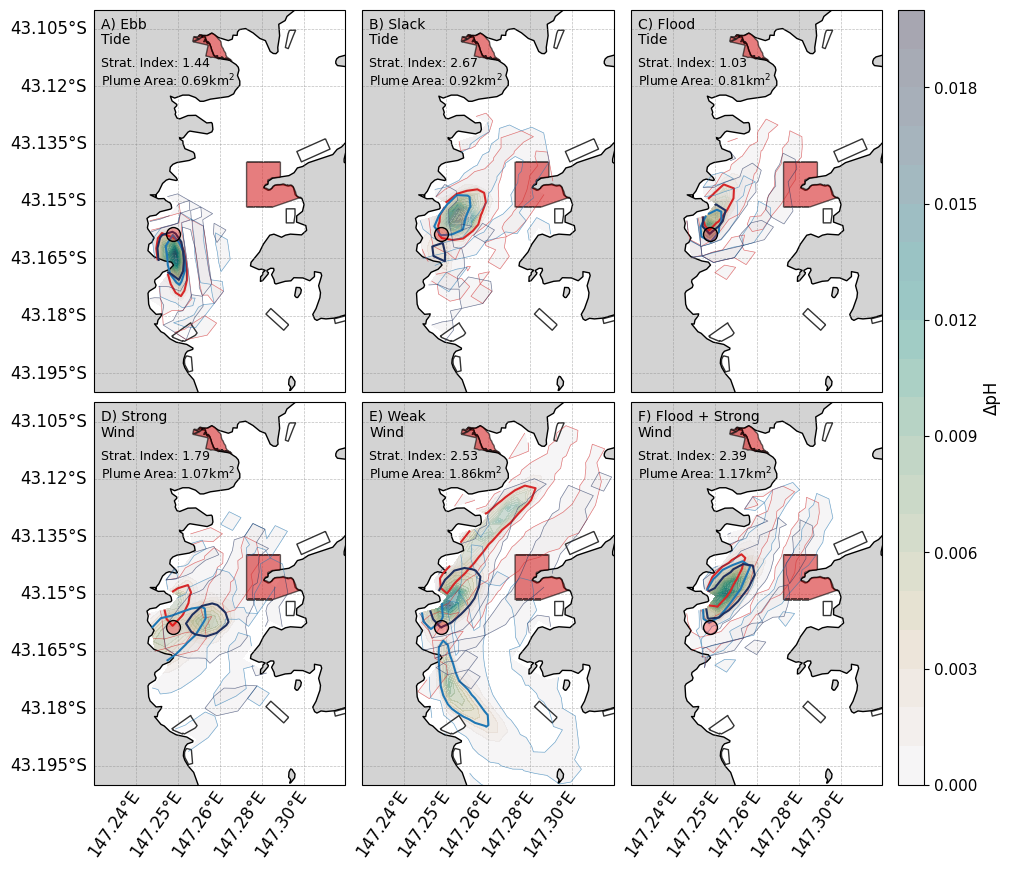

In [15]:
fig,axes = plt.subplots(2,3,figsize=(10,10),subplot_kw={'projection': ccrs.PlateCarree()},layout="compressed")

fancy_names = ['A) Ebb\nTide',
               'B) Slack\nTide',
               'C) Flood\nTide',
               'D) Strong\nWind',
               'E) Weak\nWind',
               'F) Flood + Strong\nWind'
              ]

lons = ctrl.longitude.values
lats = ctrl.latitude.values

ax = axes.flatten()

filled_marker_style = dict(marker='o', linestyle=None, markersize=10,
                                   markerfacecolor=(1, 0, 0, 0.3), #transparent red
                                   markeredgecolor='black')

cols = ['tab:red','tab:blue','#1F305E']

plume_size_mean = {}
s_index_mean = {}

for name in names:
    df_filter = [col for col in plumes.columns if name in col]
    max_plumes_ = []
    max_plumes_.append(plumes[df_filter].max(axis=0))
    s_idx = []
    for c in cats:
        s_idx.append(strat_idx[c][name])

    plume_size_mean[name] = np.mean(max_plumes_)
    s_index_mean[name] = np.nanmean(s_idx)

plot_with_custom_grid(fig, ax, 2, 3)

for i,name in enumerate(names):

    ax[i].set_extent([147.22,147.31,-43.1,-43.2])

    for x,c in enumerate(cats):

        data = ph_plume[c][name]
    
        ph_plt = ax[i].contourf(lons,lats,data,
                                cmap=cmocean.cm.rain,
                                levels=np.round(np.linspace(0.000,0.02,21),3),alpha=0.4,
                                zorder=1)

        meas = ax[i].contour(lons,lats,data,
                                colors=cols[x],
                                levels=[0.003],
                                zorder=4)

        meas_0 = ax[i].contour(lons,lats,data,
                                    colors=cols[x],
                                    levels=[0.0],alpha=0.6,linewidths=0.5,
                                    zorder=4)


    coast_plt = tas_map['coast'].plot(color='lightgrey',edgecolor='black',zorder=2,ax=ax[i])

    ax[i].text(147.2225,-43.109,fancy_names[i],fontsize=10)

    strat_idx = np.round(float(s_index_mean[name]),2)
    plume_max = np.round(float(plume_size_mean[name]),2)

    ax[i].text(147.2225,-43.12,f'Strat. Index: {strat_idx}\nPlume Area: {plume_max}km$^2$',fontsize=9)
    
    inject_site = ax[i].plot(ctrl.longitude[63,30],ctrl.latitude[63,30],**filled_marker_style,zorder=10)
    
    farm_plt = farms_within_domain.plot(color='white',alpha=0.8,
                                            ax=ax[i],zorder=3,edgecolor='black',label='Aquaculture')
    for res in reserves:
        
            resers = res_locs[res_locs['NAME_SHORT'] == res].copy()
        
            if (res != 'Simpsons Point Marine CA') and (res != 'Central Channel Marine CA') and (res != 'Snake Bay CA'):
            
                res_plt = resers.plot(color='tab:red',alpha=0.6,
                                    edgecolor='black',
                                    zorder=3,ax=ax[i])
                
         
fig.colorbar(ph_plt, ax=ax.ravel().tolist(),pad=0.02,aspect=30,label='ΔpH')
fig.savefig('All_Plume_Dispersion_Maps.pdf',dpi=300)

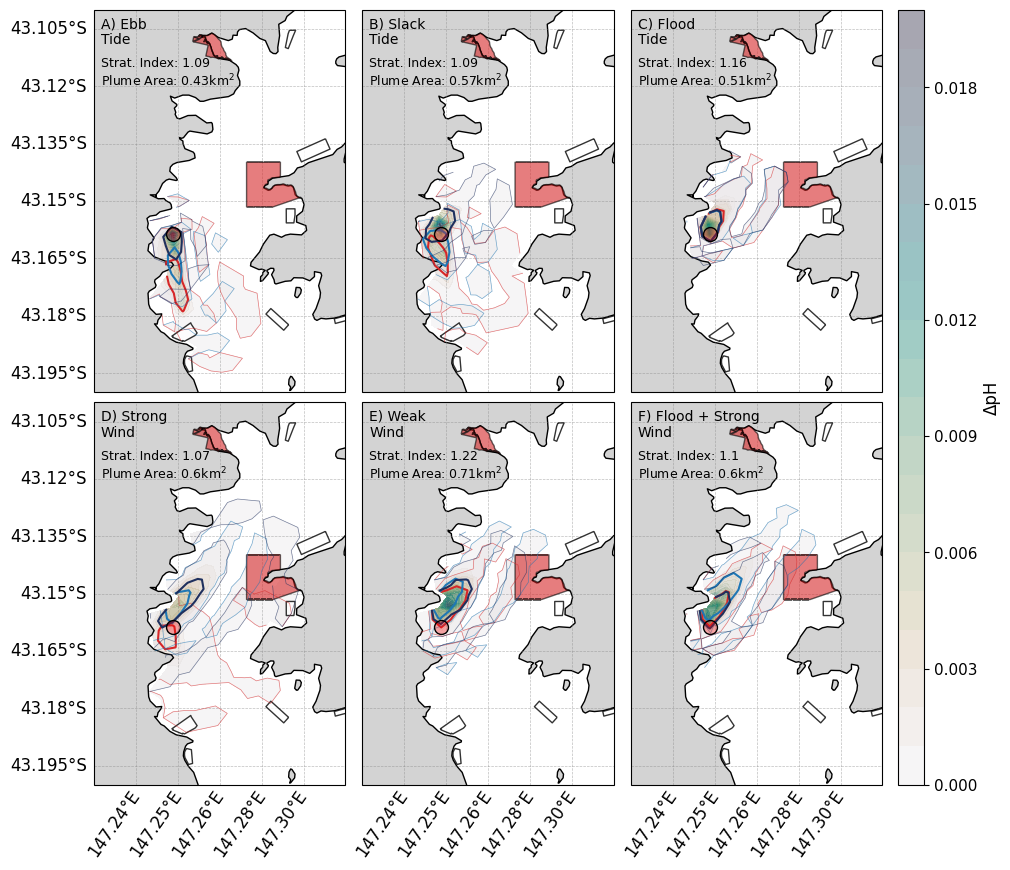

In [16]:
fig,axes = plt.subplots(2,3,figsize=(10,10),subplot_kw={'projection': ccrs.PlateCarree()},layout="compressed")

ax = axes.flatten()

filled_marker_style = dict(marker='o', linestyle=None, markersize=10,
                                   markerfacecolor=(1, 0, 0, 0.3), #transparent red
                                   markeredgecolor='black')

cols = ['tab:red','tab:blue','#1F305E']

plume_size_mean = {}
s_index_mean = {}

for name in names:
    df_filter = [col for col in w_plumes.columns if name in col]
    max_plumes_ = []
    max_plumes_.append(w_plumes[df_filter].max(axis=0))
    s_idx = []
    for c in cats:
        s_idx.append(w_strat_idx[c][name])

    plume_size_mean[name] = np.mean(max_plumes_)
    s_index_mean[name] = np.nanmean(s_idx)

plot_with_custom_grid(fig, ax, 2, 3)

for i,name in enumerate(names):

    ax[i].set_extent([147.22,147.31,-43.1,-43.2])

    for x,c in enumerate(cats):

        data = w_ph_plume[c][name]
    
        ph_plt = ax[i].contourf(lons,lats,data,
                                cmap=cmocean.cm.rain,
                                levels=np.round(np.linspace(0.000,0.02,21),3),alpha=0.4,
                                zorder=1)

        meas = ax[i].contour(lons,lats,data,
                                colors=cols[x],
                                levels=[0.003],
                                zorder=4)

        meas_0 = ax[i].contour(lons,lats,data,
                                    colors=cols[x],
                                    levels=[0.0],alpha=0.6,linewidths=0.5,
                                    zorder=4)


    coast_plt = tas_map['coast'].plot(color='lightgrey',edgecolor='black',zorder=2,ax=ax[i])

    ax[i].text(147.2225,-43.109,fancy_names[i],fontsize=10)

    strat_idx = np.round(float(s_index_mean[name]),2)
    plume_max = np.round(float(plume_size_mean[name]),2)

    ax[i].text(147.2225,-43.12,f'Strat. Index: {strat_idx}\nPlume Area: {plume_max}km$^2$',fontsize=9)
    
    inject_site = ax[i].plot(ctrl.longitude[63,30],ctrl.latitude[63,30],**filled_marker_style,zorder=10)
    
    farm_plt = farms_within_domain.plot(color='white',alpha=0.8,
                                            ax=ax[i],zorder=3,edgecolor='black',label='Aquaculture')
    for res in reserves:
        
            resers = res_locs[res_locs['NAME_SHORT'] == res].copy()
        
            if (res != 'Simpsons Point Marine CA') and (res != 'Central Channel Marine CA') and (res != 'Snake Bay CA'):
            
                res_plt = resers.plot(color='tab:red',alpha=0.6,
                                    edgecolor='black',
                                    zorder=3,ax=ax[i])
                    
fig.colorbar(ph_plt, ax=ax.ravel().tolist(),pad=0.02,aspect=30,label='ΔpH')
fig.savefig('All_Plume_Dispersion_Maps_Winter.pdf',dpi=300)